In [224]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
from sklearn.metrics import mean_squared_error

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [225]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [226]:
df = pd.read_csv('stock.csv')
tickerSymbol = '^NSEI'
data = yf.Ticker(tickerSymbol)

In [227]:
prices = data.history(start='2022-03-07', end='2023-03-03').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

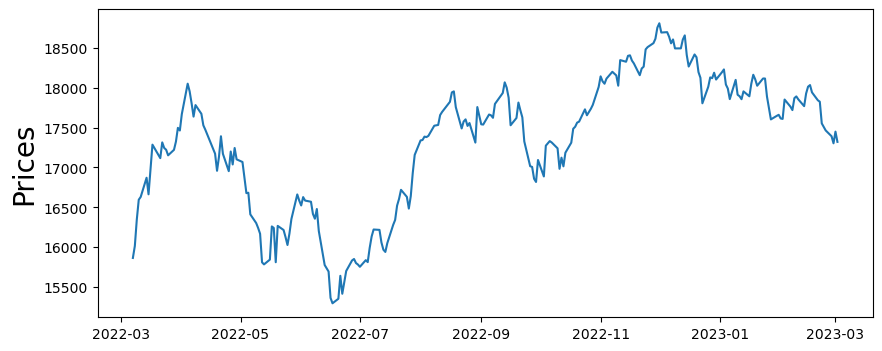

In [228]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

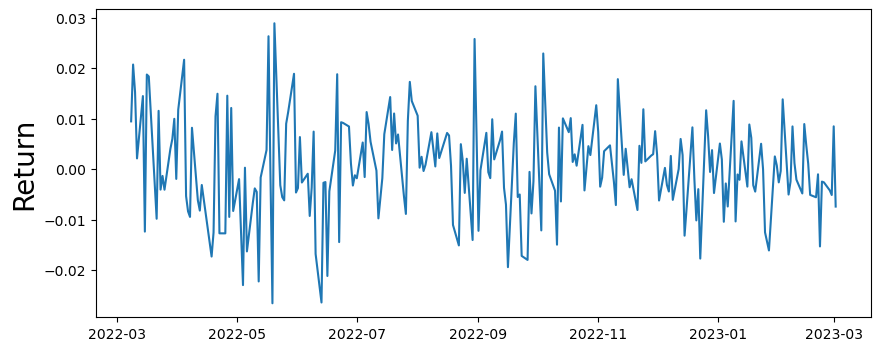

In [229]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

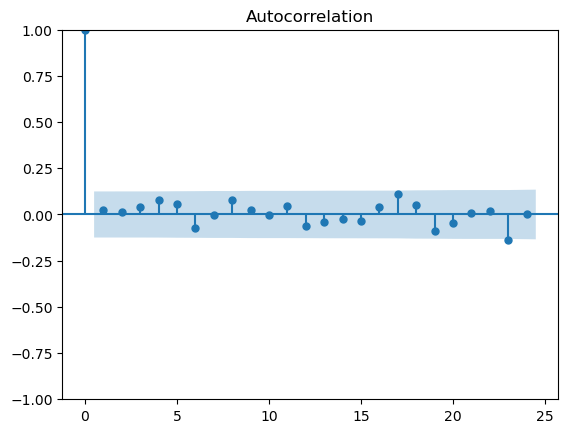

In [230]:
plot_acf(returns)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


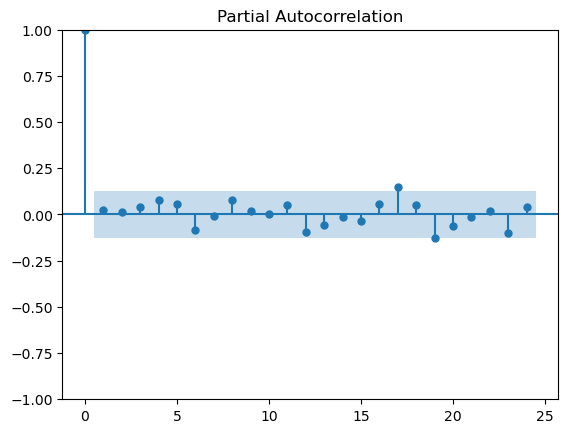

In [231]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying 

100%|██████████| 233/233 [00:00<00:00, 4261.37it/s]


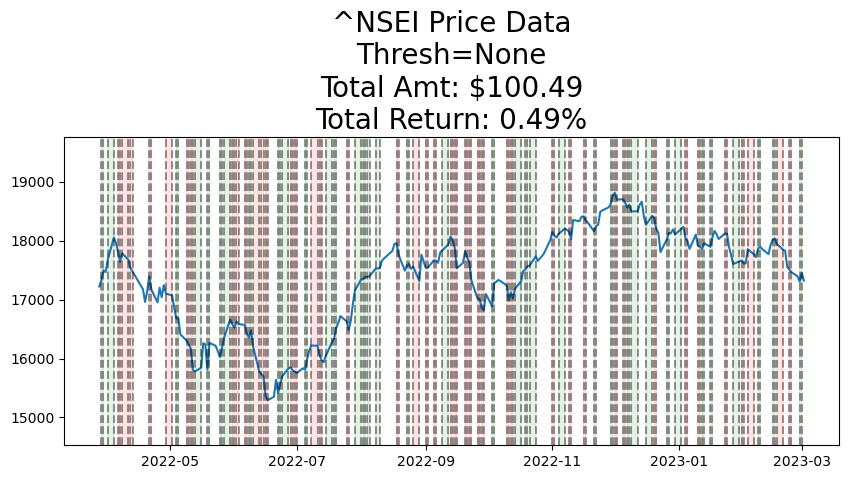

100.48750649529232

In [232]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [233]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 233/233 [00:00<00:00, 4759.94it/s]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $100.42\nSD: $6.5')

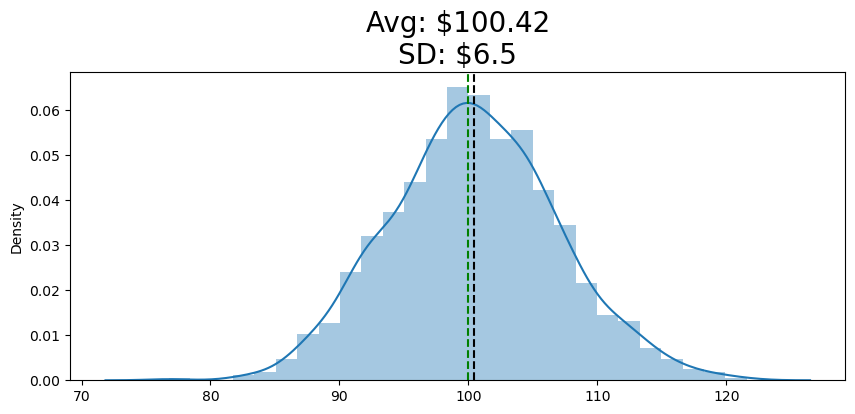

In [234]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|██████████| 233/233 [00:00<00:00, 5083.37it/s]


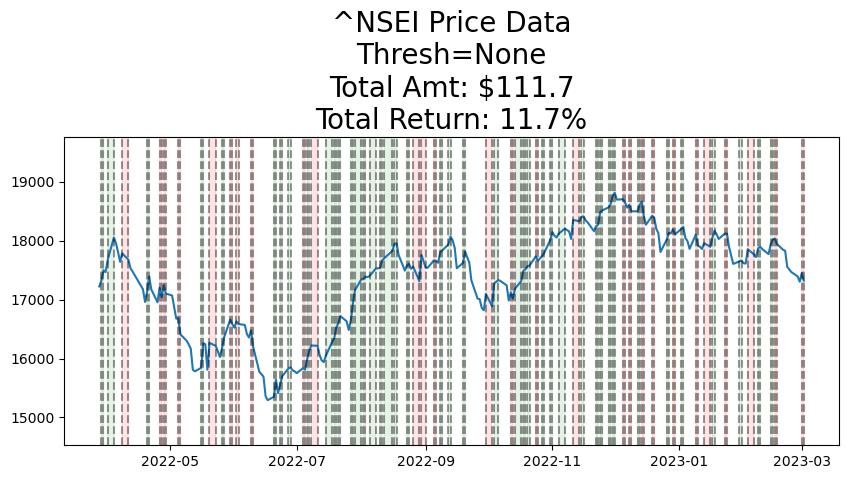

111.69999179868401

In [235]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

# Try AR(1) Model

100%|██████████| 233/233 [00:00<00:00, 308.19it/s]


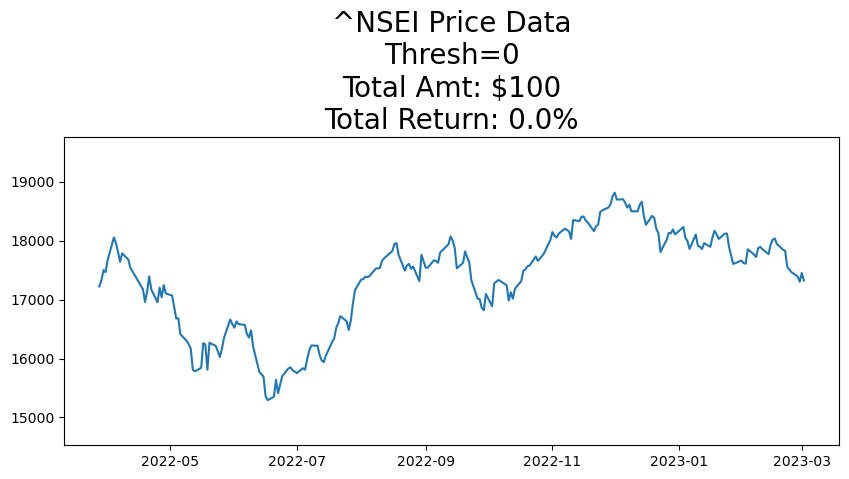

100%|██████████| 233/233 [00:00<00:00, 305.95it/s]


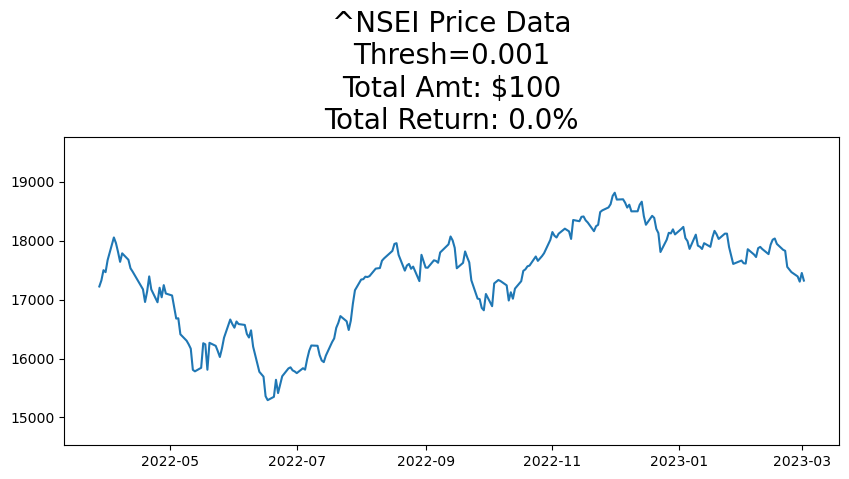

100%|██████████| 233/233 [00:00<00:00, 311.35it/s]


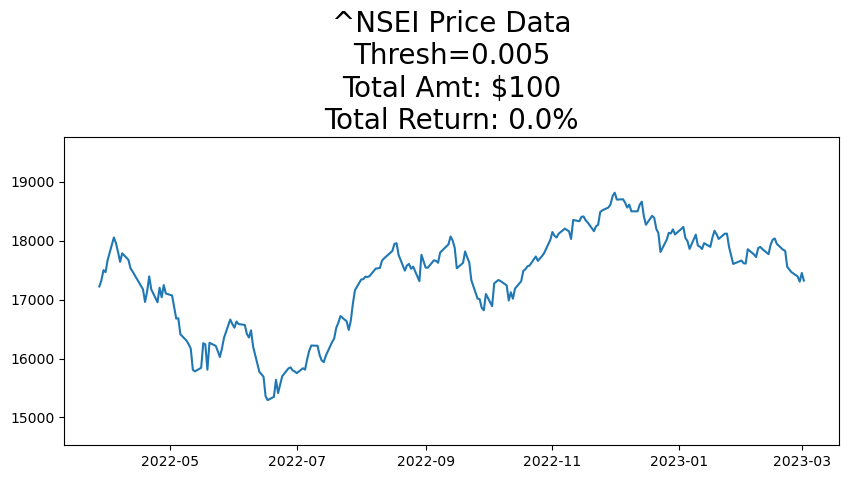

In [236]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(5) Model

100%|██████████| 233/233 [00:00<00:00, 311.05it/s]


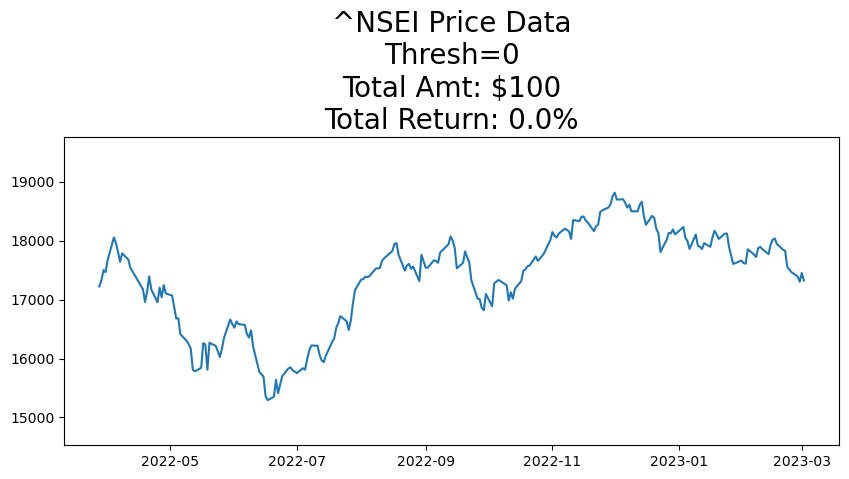

100%|██████████| 233/233 [00:00<00:00, 300.12it/s]


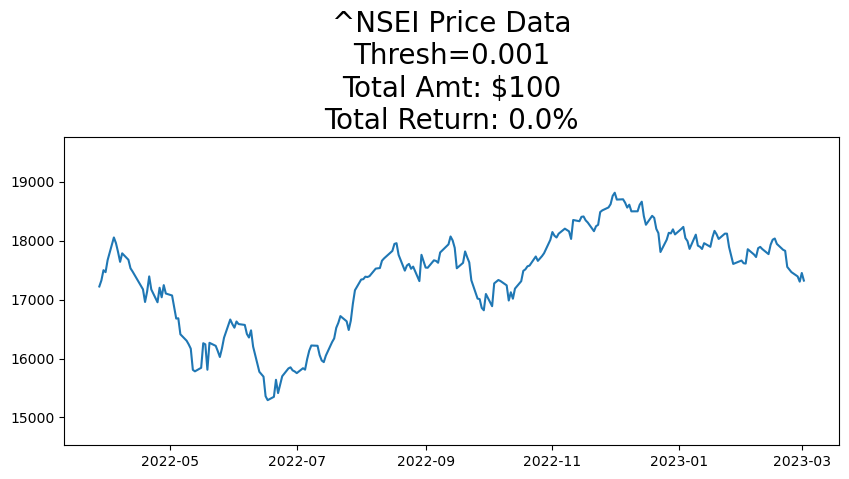

100%|██████████| 233/233 [00:00<00:00, 310.50it/s]


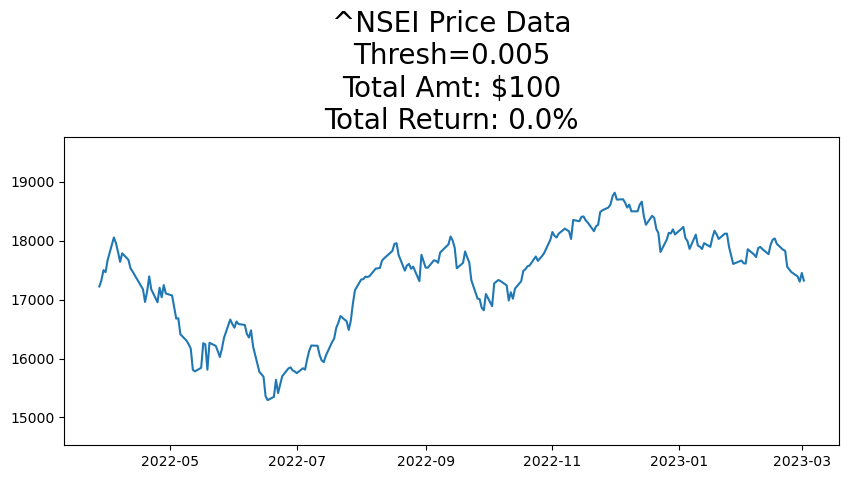

In [237]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

100%|██████████| 233/233 [00:00<00:00, 313.75it/s]


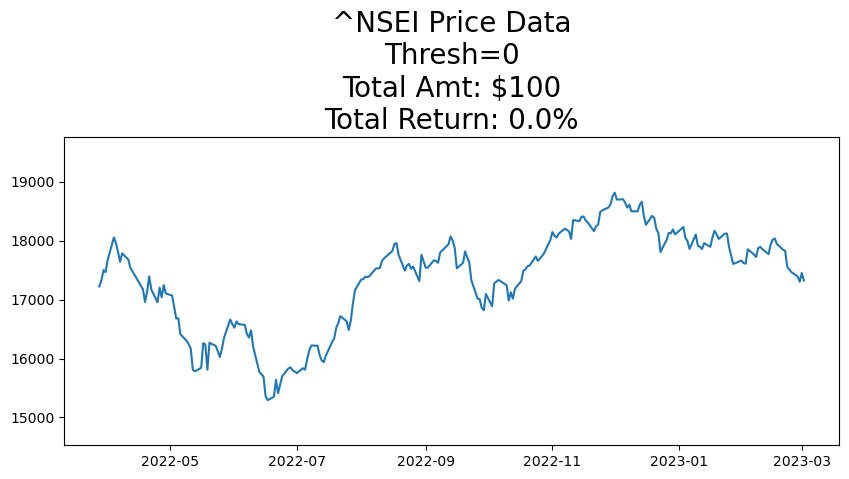

100%|██████████| 233/233 [00:00<00:00, 279.29it/s]


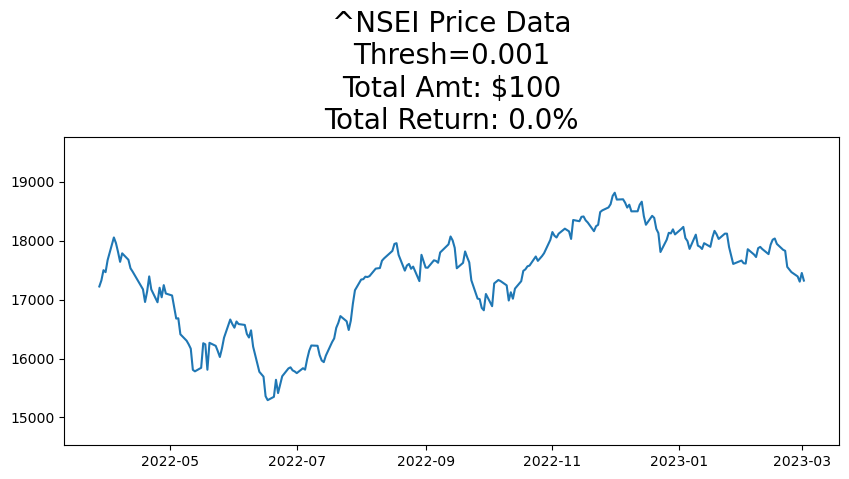

100%|██████████| 233/233 [00:00<00:00, 279.84it/s]


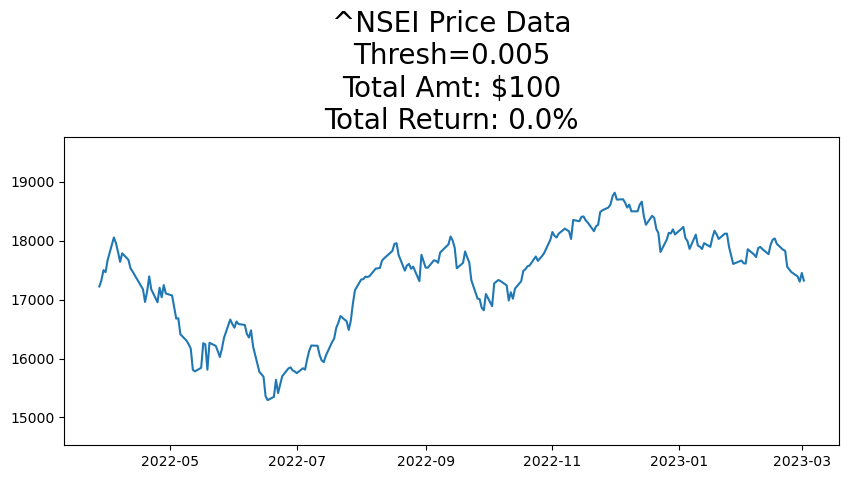

In [238]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)

In [239]:
df = pd.read_csv('stock.csv')
df = df[['Date', 'Close']]
df = df.set_index('Date')


In [240]:
df = pd.read_csv('C:\\Users\Tejaswini\Downloads\stock.csv')
df = df[['Date', 'Close']]
df = df.set_index('Date')

In [241]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
date_range = pd.date_range(start='2022-03-07', end='2023-03-03', freq='A')

# create a DataFrame with the date range as the index
df = pd.DataFrame(index=date_range)


In [242]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
data = pd.read_csv('C:\\Users\Tejaswini\Downloads\stock.csv', index_col='Date')

# convert data to a numpy array
train = data['Open'].to_numpy(dtype=np.float64)

# create and fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# make predictions for the next day
predictions = model_fit.forecast(steps=1)

# print the predicted price for the next day
print('Predicted price for the next day:', predictions[0])


Predicted price for the next day: 17447.020036141763


In [243]:
import yfinance as yf

# Get live data for NSEI
nsei = yf.Ticker("^NSEI")
data = nsei.history(period="1d")

# Get the latest closing price
latest_price = data['Close'][-1]

# Print the latest closing price
print("Latest closing price for NSEI:", latest_price)

Latest closing price for NSEI: 17777.44921875
